Import bibliotek

In [71]:
import torch
import random
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
import tensorflow as tf
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import os
import pandas as pd
from dataclasses import dataclass, asdict
from typing import List, Tuple, Dict, Optional
from sklearn.metrics import confusion_matrix, classification_report

Wnioski z zadania 1:
- nie zawsze warto mieć wszystkie dane, ale też czasami warto nie usuwać ich
- czasami rzeczy nieoczywiste mogą mieć wpływ
- warto pokazywać różne perspektywy

Załadowanie zbioru danych, normalizacja oraz DataLoadery z ustawieniem ziarna

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def parameters_count(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

set_seed(42)

def get_dataloaders(
    data_dir: str = "./data",
    batch_train: int = 128,
    batch_eval: int = 1000,
    seed: int = 42,
    val_size: int = 10000
    ):
    set_seed(seed)

    mean, std = (0.1307,), (0.3081,)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    full_train = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
    test_ds = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

    train_size = len(full_train) - val_size
    val_size = val_size
    train_ds, val_ds = random_split(
        full_train, [train_size, val_size],
        generator=torch.Generator().manual_seed(seed)
    )

    train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_eval, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_eval, shuffle=False)

    return train_loader, val_loader, test_loader

Using device: cpu


Funkcje pod trening, podsumowanie, predykcja

In [73]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    total_loss, correct, n = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        # forward
        outputs = model(X)
        loss = loss_fn(outputs, y)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # statystyki
        total_loss += loss.item() * X.size(0)
        correct += (outputs.argmax(1) == y).sum().item()
        n += X.size(0)

    avg_loss = total_loss / n
    acc = correct / n
    return avg_loss, acc


@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss, correct, n = 0, 0, 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = loss_fn(outputs, y)

        total_loss += loss.item() * X.size(0)
        correct += (outputs.argmax(1) == y).sum().item()
        n += X.size(0)

    avg_loss = total_loss / n
    acc = correct / n
    return avg_loss, acc


def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=5):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoka {epoch+1}/{epochs} | "
              f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Val: loss={val_loss:.4f}, acc={val_acc:.4f}")

    return history

Baseline

In [74]:
class Baseline(nn.Module):
    def __init__(self, hidden: int = 128, dropout: float = 0.0):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden)
        self.do = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.fc2 = nn.Linear(hidden, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.do(x)
        x = self.fc2(x)
        return x

Konwolucyjna sieć neuronowa

In [75]:
class SimpleCNN(nn.Module):
    def __init__(self, channels=32, dropout=0.25, use_batchnorm=False):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels*2, kernel_size=3, padding=1)

        self.use_bn = use_batchnorm
        if self.use_bn:
            self.bn1 = nn.BatchNorm2d(channels)
            self.bn2 = nn.BatchNorm2d(channels*2)

        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear((channels*2)*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        if self.use_bn: x = self.bn1(x)
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        if self.use_bn: x = self.bn2(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x

Trening modeli oraz ich test + różne eksperymenty

In [76]:
train_loader, val_loader, test_loader = get_dataloaders()
loss_fn = nn.CrossEntropyLoss()

mlp = Baseline().to(device) # podstawowy MLP
opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01)
print("Trening Baseline'u:")
history_mlp = train_model(mlp, train_loader, val_loader, loss_fn, opt_mlp, device, epochs=10)

cnn = SimpleCNN(channels=32, dropout=0.25, use_batchnorm=True).to(device) # podstawowy CNN
opt_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)
print("\nTrening CNN:")
history_cnn = train_model(cnn, train_loader, val_loader, loss_fn, opt_cnn, device, epochs=10)

cnn_small = SimpleCNN(channels=16, dropout=0.25, use_batchnorm=False).to(device) # mniejsza liczba kanałów
opt_small = torch.optim.Adam(cnn_small.parameters(), lr=0.001)
print("\nCNN - mniej kanałów:")
history_small = train_model(cnn_small, train_loader, val_loader, loss_fn, opt_small, device, epochs=5)

cnn_big = SimpleCNN(channels=64, dropout=0.25, use_batchnorm=False).to(device) # większa liczba kanałów
opt_big = torch.optim.Adam(cnn_big.parameters(), lr=0.001)
print("\nCNN - więcej kanałów:")
history_big = train_model(cnn_big, train_loader, val_loader, loss_fn, opt_big, device, epochs=5)

cnn_bn = SimpleCNN(channels=32, dropout=0.25, use_batchnorm=True).to(device) # z BatchNorm'em
opt_bn = torch.optim.Adam(cnn_bn.parameters(), lr=0.001)
print("\nCNN - z BatchNorm:")
history_bn = train_model(cnn_bn, train_loader, val_loader, loss_fn, opt_bn, device, epochs=5)

cnn_do = SimpleCNN(channels=32, dropout=0.5, use_batchnorm=True).to(device) # zwiększenie Dropout'u
opt_do = torch.optim.Adam(cnn_do.parameters(), lr=0.001)
print("\nCNN - większy Dropout:")
history_do = train_model(cnn_do, train_loader, val_loader, loss_fn, opt_do, device, epochs=5)

Trening Baseline'u:
Epoka 1/10 | Train: loss=0.2723, acc=0.9190 | Val: loss=0.1949, acc=0.9436
Epoka 2/10 | Train: loss=0.1545, acc=0.9551 | Val: loss=0.1940, acc=0.9466
Epoka 3/10 | Train: loss=0.1406, acc=0.9601 | Val: loss=0.2112, acc=0.9457
Epoka 4/10 | Train: loss=0.1334, acc=0.9638 | Val: loss=0.1777, acc=0.9573
Epoka 5/10 | Train: loss=0.1184, acc=0.9680 | Val: loss=0.1905, acc=0.9568
Epoka 6/10 | Train: loss=0.1231, acc=0.9668 | Val: loss=0.2112, acc=0.9545
Epoka 7/10 | Train: loss=0.1120, acc=0.9706 | Val: loss=0.2141, acc=0.9580
Epoka 8/10 | Train: loss=0.1052, acc=0.9720 | Val: loss=0.2110, acc=0.9560
Epoka 9/10 | Train: loss=0.1076, acc=0.9723 | Val: loss=0.2459, acc=0.9549
Epoka 10/10 | Train: loss=0.1025, acc=0.9743 | Val: loss=0.2604, acc=0.9579
Trening CNN:
Epoka 1/10 | Train: loss=0.1264, acc=0.9602 | Val: loss=0.0494, acc=0.9842
Epoka 2/10 | Train: loss=0.0432, acc=0.9865 | Val: loss=0.0517, acc=0.9857
Epoka 3/10 | Train: loss=0.0299, acc=0.9902 | Val: loss=0.0402, ac

Ciekawostka - tylko ten fragment kodu robił mi się przez 54 minuty - w sumie 40 epok XDD

Podsumowanie tego:
Zmiany robiłem na CNN'ie, gdyż jest lepszym modelem pod to zadanie. Zmiana kanałów praktycznie nie zmieniała wyników dokładności i straty. Podobnie z BatchNormem oraz Dropoutem - minimalnie się różnią wyniki, ale warto było sprawdzić to

Wizualizacja

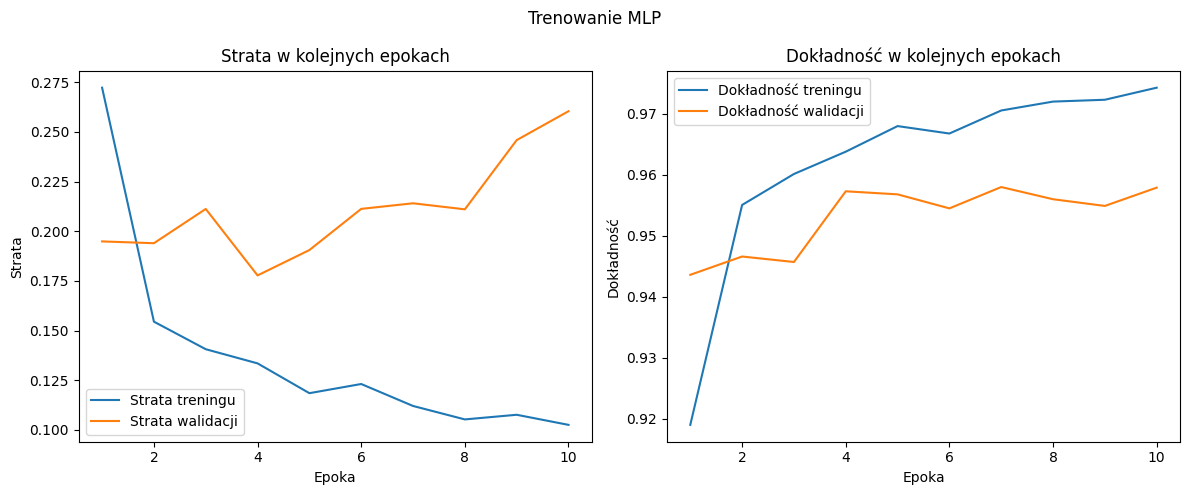

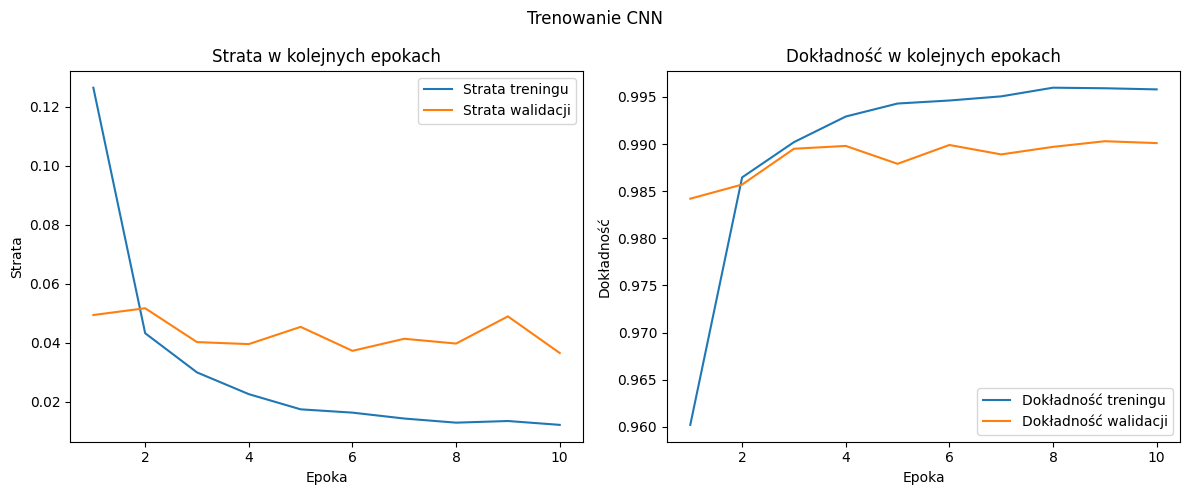

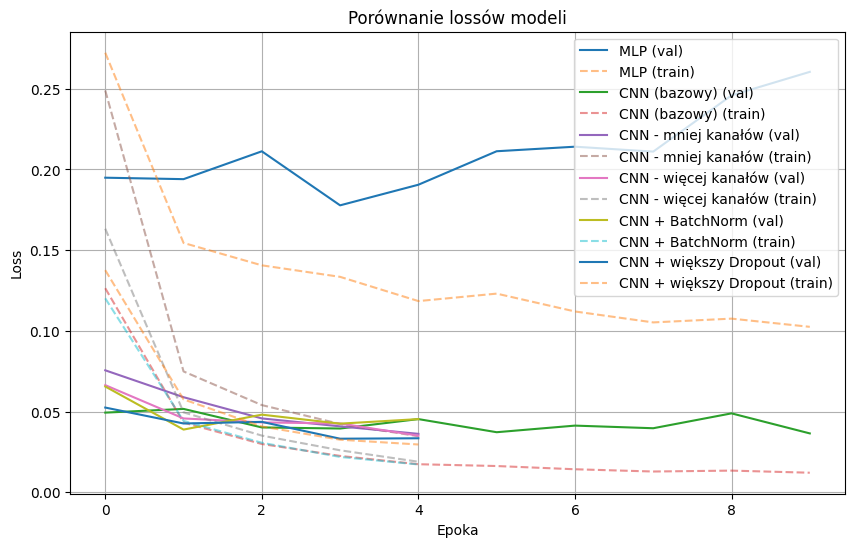

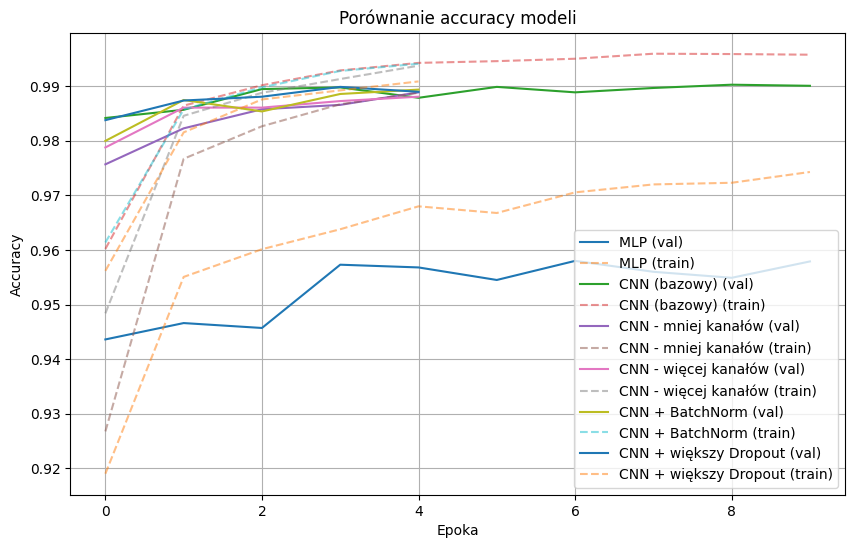

In [77]:
def plot_history(history, title="Training history"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Strata treningu")
    plt.plot(epochs, history["val_loss"], label="Strata walidacji")
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.title("Strata w kolejnych epokach")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Dokładność treningu")
    plt.plot(epochs, history["val_acc"], label="Dokładność walidacji")
    plt.xlabel("Epoka")
    plt.ylabel("Dokładność")
    plt.title("Dokładność w kolejnych epokach")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_history(history_mlp, title="Trenowanie MLP")
plot_history(history_cnn, title="Trenowanie CNN")

print("")
histories = {
    "MLP": history_mlp,
    "CNN podstawowy": history_cnn,
    "CNN mniej kanałów": history_small,
    "CNN więcej kanałów": history_big,
    "CNN BatchNorm": history_bn,
    "CNN większy Dropout": history_do
}

plt.figure(figsize=(10,6))
for name, history in histories.items():
    plt.plot(history['val_loss'], label=f"{name} (walidacja)")
    plt.plot(history['train_loss'], linestyle='--', alpha=0.5, label=f"{name} (trening)")

plt.title("Porównanie strat w danym modelu i parametrach")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.grid(True)
plt.show()

if 'val_acc' in history_mlp:
    plt.figure(figsize=(10,6))
    for name, history in histories.items():
        plt.plot(history['val_acc'], label=f"{name} (walidacja))")
        plt.plot(history['train_acc'], linestyle='--', alpha=0.5, label=f"{name} (trening)")

    plt.title("Porównanie dokładności modeli")
    plt.xlabel("Epoka")
    plt.ylabel("Dokładność")
    plt.legend()
    plt.grid(True)
    plt.show()

Wnioski:
- Model MLP osiąga duże straty dla danych walidacyjnych (rosną wraz z epokami) w stosunku do malejących strat w danych treningowych - zachodzi overfitting
- Model MLP osiąga dużą dokładność walidacji, która nieznacznie odbiega od tej treningowej (parę p.p.)
- Model CNN ma praktycznie idealną dokładność zarówno danych treningowych, jak i walidacyjnych - świetnie się sprawdza zatem w takim zadaniu
- MODEL CNN ma całkiem niskie straty (po chwili mniej niż 6%), jednakże są lekkie różnice w stratach między tymi danych
- W różnych wariantach modelu CNN widać zwykle małe różnice, ale małoznaczące raczej

Ewaluacja i macierz pomyłek

Dokładność testu dla MLP: 0.9612
Dokładność testu dla CNN: 0.9897



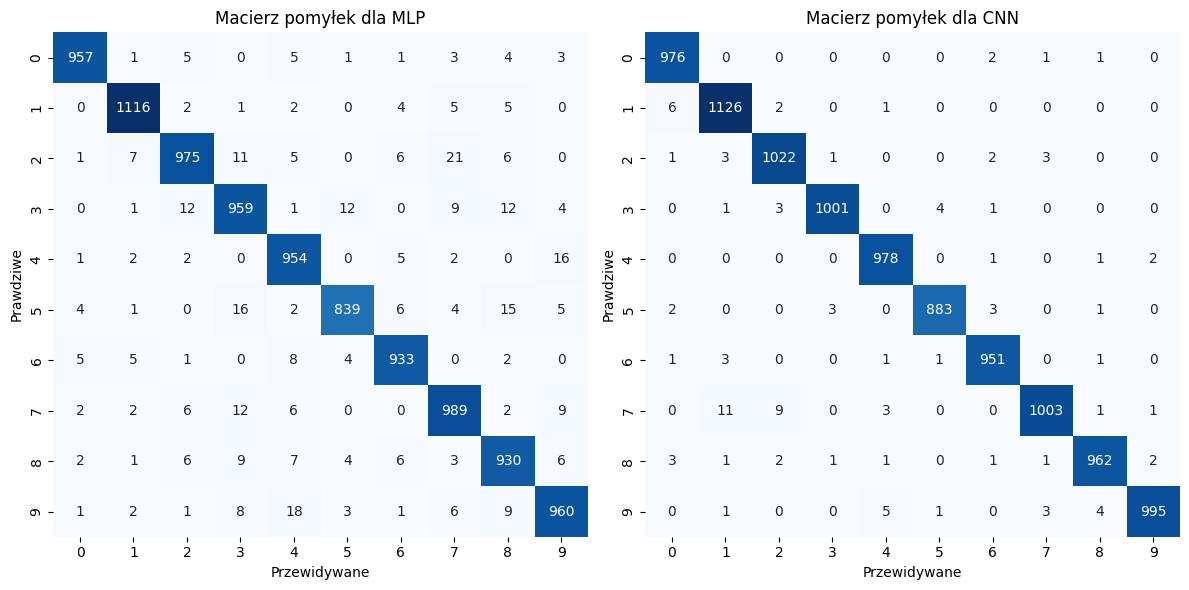

In [78]:
def test_and_confusion(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    cm = confusion_matrix(y_true, y_pred)
    return acc, cm


acc_mlp, cm_mlp = test_and_confusion(mlp, test_loader, device)
print(f"Dokładność testu dla MLP: {acc_mlp:.4f}")

acc_cnn, cm_cnn = test_and_confusion(cnn, test_loader, device)
print(f"Dokładność testu dla CNN: {acc_cnn:.4f}")
print("")

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Macierz pomyłek dla MLP")
plt.xlabel("Przewidywane")
plt.ylabel("Prawdziwe")

plt.subplot(1,2,2)
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Macierz pomyłek dla CNN")
plt.xlabel("Przewidywane")
plt.ylabel("Prawdziwe")

plt.tight_layout(w_pad=1)
plt.show()


Wnioski:
- Oba modele osiągają wysoką dokładność dla danych testowych, jednakże wyższą ma sieć konwolucyjna (kto by się spodziewał)
- Z macierzy pomyłek widać całkiem dużą przewagę dla CNN
- Z ciekawostek, to CNN miał największy problem z liczbą 7, którą widział jako 1 lub 2

Wnioski końcowe:
- spędziłem nad tym strasznie dużo czasu, ale się wiele nauczyłem :)))
- zobaczyłem, że model CNN świetnie nadaje się do wykrywania cyferek ręcznie napisanych
- wykresy i liczby świetnie ilustrują wszelkie parametry tych modeli